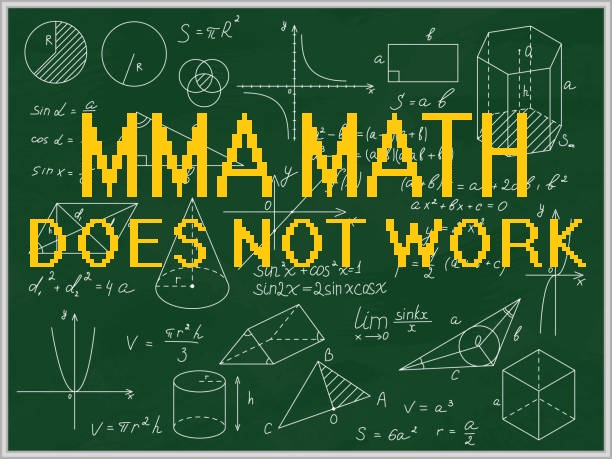

# Does the addage "MMA math doesn't work" add up?

  Arguing over the outcome of future sporting events has a history that surely dates back to the origin of sport itself. There are TV channels that boast panels of professional sports analysts in heated debates about how famous teams or indivuals from the past would compare against the best of today. There are 'Fantasy' magazines and websites, issuing detailed statistical predictions for player performance a full season in advance. Often these arguments will include complex statistical insights that would seem to have no plauseable bearing on the event at hand, but almost invariably, sports math will be used at some point in the course of the debate. It seems only natural that if team A has beaten team X, and team B lost to team X, that team A will beat team B. In the arena of mixed martial arts this concept is called "MMA math", and on any platform hosting a discussion on an upcoming event you will find someone using this concept and someone else replying "MMA math doesn't work". Well, does it? Let's find out!

### Objective

Using this fantastic [dataset](https://www.kaggle.com/rajeevw/ufcdata) of historical UFC fights compiled by [Rajeev Warrier](https://www.kaggle.com/rajeevw), I am going to build a model to test the predictive value of "MMA math". Lets get it on! 



In [ ]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#read in raw data set
raw_data = pd.read_csv('data.csv', parse_dates= [3])
raw_data.shape

### Transforming the data
This data set was originally assembled for use to build a machine learning model, so the author combined a dataset of fighter records and attributes, with a dataset of match statistics and results. For my purposes, I only need a dataset with a row for each match, that has the winner, the loser and the date of the event. There were 110 matches that were a 'draw', with no winner, that I dropped from the dataset, since MMA math requires wins and losses. I also kept the weightclass column for possible futher exploration. 

In [ ]:
# creating new columns to indicate the winner and loser of each fight
data = pd.DataFrame(raw_data)
data.loc[data['Winner']=='Blue', 'won'] = data['B_fighter']
data.loc[data['Winner']=='Red', 'won'] = data['R_fighter']
data.loc[data['Winner']=='Blue', 'lost'] = data['R_fighter']
data.loc[data['Winner']=='Red', 'lost'] = data['B_fighter']

#consolidate new dataframe
cols = ['won', 'lost', 'date', 'weight_class']
mma = pd.DataFrame(data[cols])
mma.dropna(axis=0, inplace=True)

mma.shape

### Making predictions

To make "MMA math" predictions, I built a function and then applied it to the dataset to generate a new column with a prediction. For each row (which represents a fight) the function takes in the names of each fighter and the date of the fight and then, for each fighter, generates a list of names of fighters that they lost to, and a list of names of fighters they beat. Each fighter gets a "point" for a fighter they beat that also beat the other fighter. Then the points are added up, and the fighter with the most points is the MMA math predicted victor. 

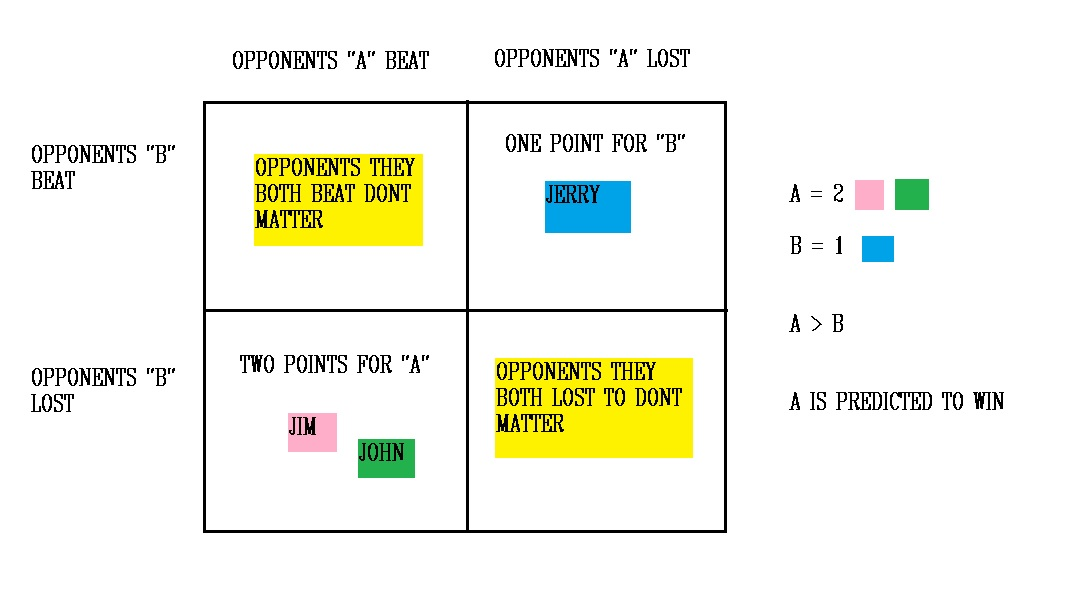

In [ ]:
#create new column with mma math predictions

def loser_count(winner_lost, loser_beat):
    count = 0
    for fighter in winner_lost:
        if fighter in loser_beat:
            count += 1
    return count

def winner_count(winner_beat, loser_lost):
    count = 0
    for fighter in loser_lost:
        if fighter in winner_beat:
            count += 1
    return count

def guys_loser_lost(lfighter, f_date):
    guys_loser_lost = mma['won'][(mma['lost']==lfighter) & (mma['date'] < f_date)]
    return list(guys_loser_lost)

def guys_winner_lost(wfighter, f_date):
    guys_winner_lost = mma['won'][(mma['lost']==wfighter) & (mma['date'] < f_date)]
    return list(guys_winner_lost)

def guys_loser_beat(lfighter, f_date):
    guys_loser_beat = mma['lost'][(mma['won']==lfighter) & (mma['date'] < f_date)]
    return list(guys_loser_beat)

def guys_winner_beat(wfighter, f_date):
    guys_winner_beat = mma['lost'][(mma['won']==wfighter) & (mma['date'] < f_date)]
    return list(guys_winner_beat)

def mma_math(df):
    """Apply to mma dataframe to generate a row with outcome predictions.
    
    Args: 
        Self (dataframe): Used with apply() method to mma dataframe.
        
    Returns: 
        Name (str): Name of fighter predicted to win for each row using "MMA math"
        
    Raises: 
        ? (str): If no name prediction can be made
        
    """
    wfighter = df['won']
    lfighter = df['lost']
    f_date = df['date']

    #list of guys the winner beat before given date
    winner_beat = guys_winner_beat(wfighter, f_date)
    #list of guys the winner lost to before given date
    winner_lost = guys_winner_lost(wfighter, f_date)
    #list of guys the loser beat before given date
    loser_beat = guys_loser_beat(lfighter, f_date)
    #list of guys the loser lost to before given date
    loser_lost = guys_loser_lost(lfighter, f_date)
    #count of guys the winner beat that the loser lost to
    win_count = winner_count(winner_beat, loser_lost) 
    #count of guys the loser beat that the loser lost to
    loss_count = loser_count(winner_lost, loser_beat)
    math = win_count - loss_count
    if math > 0:
        return wfighter
    elif math < 0:
        return lfighter
    else: return '?'

mma['math_prediction'] = mma.apply(mma_math, axis=1)


### Problems
Right away we can start to see a big issue with making predictions using MMA math. There simply aren't very many opportunities to use it. Of the 6012 total fights in our dataset, only 516 are able to generate a prediction using my MMA math model. That's only about 9%! So even if this prediction method were to be highly accurate, it could only be used about 10% of the time. There are several contributing factors to this situation that deserve a little examination.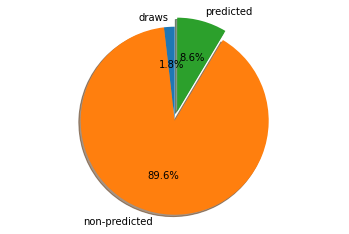

1) **Fighters don't fight frequently**. Right now the UFC has roughly [689](https://sqaf.club/how-many-fighters-in-ufc-currently/) fighters on its roster and last year there were about 477 fights, creating an average of 1.3 fights per year for each fighter. Of course some fighters were more active and some were absent the entire year, so the actual mean was 1.6 fights per active fighter, with one fighter entering the cage an astonishing 6 times in one year! Here is a graph of the breakdown. 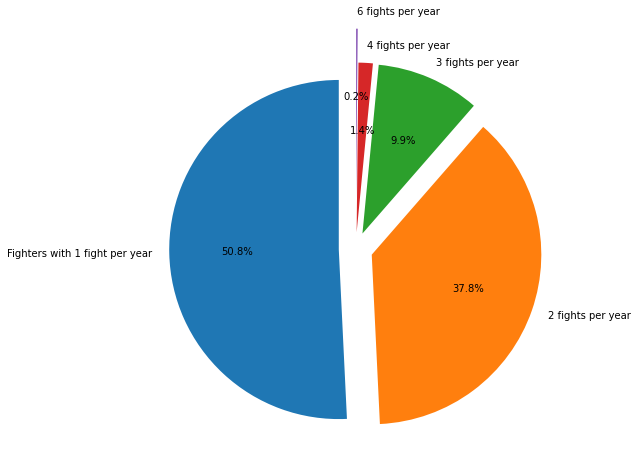 

2) **Fighters don't fight many times** Only 20 people in the UFC history have fought more than 25 times. Nearly half of all UFC combatants only enter the cage 1-3 times in their entire career. Even the fighters that have made it all the way to at least 1 title bout only average just over 11 total career fights. It's beyond the scope of this project, but it might be worth seeing if MMA math has more predictive value for title bouts. 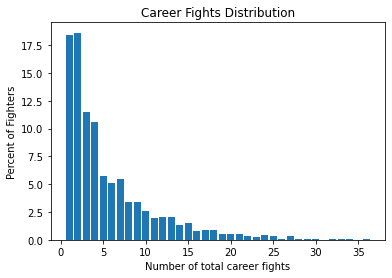 

3) **Fighters change weight classes** While some fighters will stay in the same division long term, the more matches they have the higher the probability that they will fight in at least one other division. When a fighter changes weight division they enter an entirely new pool of potential opponents which greatly reduces their chances of a matchup where MMA math can apply.
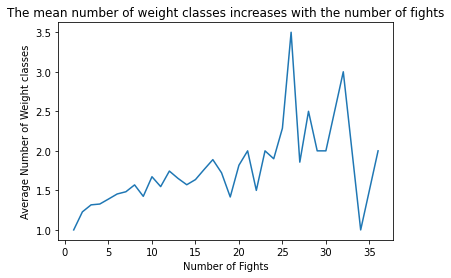
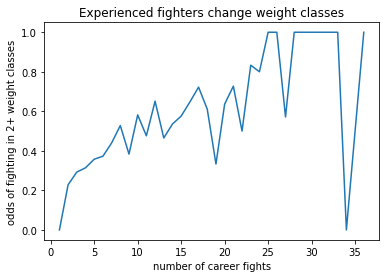

4) **Fighters change over time** One of the biggest arguments against MMA math is that even when two fighters have fought the same opponant with different outcomes, that opponant has often either improved or declined inbetween matches. Perhaps that opponant lost early in their career from lack of experience, or lost later in their career after their performance had declined.

All that aside, let's see how our MMA math predictions actually perform!

In [ ]:
# creating new df with only the rows that contained an MMA math prediction
math = mma[mma['math_prediction']!='?'].copy()

# creating new column to check the prediction accuracy
def correct(line):
    if line.loc['won'] == line.loc['math_prediction']:
        return True
    else: return False

math['correct'] = math.apply(correct, axis=1)

# returning the MMA math prediction accuracy
math_accuracy = int((math['correct'].sum() / math.shape[0]) * 100)
print('mma math prediction accuracy is ', str(math_accuracy), '%')

### Comparisons
With an accuracy of only 56%, MMA math delivers only a slightly higher predictive value than a coinflip, but this is after all, a sport where either athlete always has "a puncher's chance" to win. Let's explore a couple of other predictive methods to see how well MMA math stacks up.

#### Last name length
Here is a quick test to see if fighters with a longer last name than their opponant are more likely to win. 

In [ ]:
# making a function to make a prediction for each fight based on last name length
def name(df):
    won = str(df['won'])
    lost = str(df['lost'])
    try: win_last_name = won.split(' ')[1]
    except: win_last_name = won.split(' ')[0]
    try: lost_last_name = lost.split(' ')[1]
    except: lost_last_name = lost.split(' ')[0]
    if len(win_last_name) > len(lost_last_name):
        return df['won']
    elif len(win_last_name) < len(lost_last_name):
        return df['lost']
    else: return '?'
    
# applying the prediction function to the mma df    
mma['name'] = mma.apply(name, axis=1)
# creating a new df without the math prediction column
mma_names = mma.drop(labels='math_prediction', axis=1).copy()
# define a function to show if each prediction was correct
def correct(line):
    if line.loc['won'] == line.loc['name']:
        return True
    else: return False

# create answer column for predictions
mma_names['correct'] = mma_names.apply(correct, axis=1)
# filter to remove rows with no prediction (last names were equal length)
df_filter = mma_names['name']!='?'
# number of predictions made
n_predictions = (mma_names['correct'][df_filter]).shape[0] 
# number of correct predictions
n_correct = mma_names[mma_names['correct']==True].shape[0]
# calculating percent of predictions correct
name_accuracy = int((mma_names['correct'][df_filter].sum() / mma_names['correct'][df_filter].shape[0]) * 100)

print('Last name length prediction accuracy is ', str(name_accuracy), '%')



#### Corner color
Another quick function to calculate predictive power of just picking the "red" corner. Before 2010 this dataset had the red corner winning 98% of the time, so I only used the data after 2010 for this experiment.

In [ ]:
# selecting dates after 2010
before_2010 = raw_data[raw_data['date']>'2010-1-1']

# calculating % of correct predictions
total = len(before_2010)
red_wins = before_2010['R_fighter'][before_2010['Winner']=='Red'].count()
blue_wins = before_2010['B_fighter'][before_2010['Winner']=='Blue'].count()
red_accuracy = (red_wins/total)*100
print('red corner wins '+str(int(red_accuracy)) +'% of the time')

In [ ]:
predictors = ['mma math', 'last name length', 'red corner']
accuracy_scores = [math_accuracy, name_accuracy, red_accuracy]

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(predictors, accuracy_scores, align='center', color=['r','g','b'])
#ax.set_yticks(predictors)
#ax.set_yticklabels(predictors)
ax.set_xlabel('prediction method')
ax.set_ylabel('% correct')
ax.set_title('How does MMA math stack up?')

plt.show()

## Conclusion

While MMA math does perform slightly better than a cointoss, it produces so few predictions that it is almost entirely useless as a prediction metric. It might be worth some further analysis to see how it performs during title bouts, or rematches, but for the purposes of machine learning it is not worth pursuing. I had a lot of fun combing through this dataset and will probably revisit it again in the future to try out some feature engineering for machine learning.  